# header

In [9]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

from google.colab import drive
from os import chdir

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
chdir(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

/content/drive/MyDrive/Gproject/MIT_glyco


In [11]:
load_name = "./data/data_for_ml.csv"
protein_list = list(pd.read_csv(load_name).protein.unique())
protein_augmented = [name for name in protein_list if exists(f'./data/data_for_ml(augmented)/{name}.csv')]

dataset = []
for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    dataset.append(pd.read_csv(load_path))
dataset = pd.concat(dataset, axis=0).reset_index(drop=True)
dataset = dataset[(dataset['SEQ']=='S') | (dataset['SEQ']=='T')].reset_index(drop=True)

positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:          ", len(protein_list))
print("total number of augmented proteins:", len(protein_augmented))
print("total number of positive sites:    ", len(positive))

total number of proteins:           272
total number of augmented proteins: 89
total number of positive sites:     185


## parameter settings

In [12]:
from src.Data import *
from src.Preprocessing import *
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 20

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['n_layers', 'n_neurons', 'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

In [13]:
from keras import backend as K
from keras.regularizers import Regularizer

class L21(Regularizer):
    def __init__(self, C=0.01):
        self.C = K.cast_to_floatx(C)

    def __call__(self, x):
        const_coeff = np.sqrt(K.int_shape(x)[1])
        return self.C*const_coeff*K.sum(K.sqrt(K.sum(K.square(x), axis=1)))

    def get_config(self):
        return {'C': float(self.l1)}

# model

In [14]:
model_name = 'sgl_groupl1_window(protein_augmented)'

x_cts   = variables.x_cts_window
x_cat   = variables.x_cat_window
y_label = variables.y_label

print(f"{len(x_cts)} x_cts: {x_cts}")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

2 x_cts: ['Proline', 'flexibility']
12 x_cat: ['SEQ', 'nS/nT', 'nAli', 'nPos', 'phi_psi', 'SS', 'side_-1', 'side_1', 'side_2', 'side_3', 'side_4', 'side_5']
1 y_label: ['positivity']
dummy x shape: (8910, 80)
dummy y shape: (8910, 1)


{0: 'Proline',
 1: 'flexibility',
 2: 'SEQ_S',
 3: 'SEQ_T',
 4: 'nS/nT_1',
 5: 'nS/nT_2',
 6: 'nS/nT_3',
 7: 'nS/nT_4',
 8: 'nS/nT_5',
 9: 'nS/nT_6',
 10: 'nS/nT_7',
 11: 'nS/nT_8',
 12: 'nS/nT_9',
 13: 'nS/nT_10',
 14: 'nS/nT_11',
 15: 'nS/nT_12',
 16: 'nS/nT_13',
 17: 'nS/nT_14',
 18: 'nS/nT_15',
 19: 'nAli_0',
 20: 'nAli_1',
 21: 'nAli_2',
 22: 'nAli_3',
 23: 'nPos_0',
 24: 'nPos_1',
 25: 'nPos_2',
 26: 'nPos_3',
 27: 'phi_psi_alpha',
 28: 'phi_psi_beta',
 29: 'phi_psi_other',
 30: 'SS_C',
 31: 'SS_E',
 32: 'SS_H',
 33: 'side_-1_cycle',
 34: 'side_-1_gly',
 35: 'side_-1_long',
 36: 'side_-1_normal',
 37: 'side_-1_pro',
 38: 'side_-1_small',
 39: 'side_-1_very_small',
 40: 'side_1_None',
 41: 'side_1_cycle',
 42: 'side_1_gly',
 43: 'side_1_long',
 44: 'side_1_normal',
 45: 'side_1_pro',
 46: 'side_1_small',
 47: 'side_1_very_small',
 48: 'side_2_None',
 49: 'side_2_cycle',
 50: 'side_2_gly',
 51: 'side_2_long',
 52: 'side_2_normal',
 53: 'side_2_pro',
 54: 'side_2_small',
 55: 'side_

## cross validation

In [15]:
# select n_layers and n_neurons as the best values of HPO
n_layers = 5
n_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{n_layers}_{n_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        x_dim = train_x.shape[1]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

        model = SGL(x_dim, y_dim)
        model.build(n_layers, n_neurons, regularizer=L21(0.0001))
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_data=[test_x, test_y], save_path=save_path, verbose=2)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[n_layers, n_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0099778270509978
up-sampled train dataset: (13960, 80) (13960, 1)
Epoch 1/10000
437/437 - 3s - loss: 1.0430 - accuracy: 0.6567 - val_loss: 1.0759 - val_accuracy: 0.6049 - 3s/epoch - 6ms/step
Epoch 2/10000
437/437 - 2s - loss: 0.9133 - accuracy: 0.6701 - val_loss: 0.9088 - val_accuracy: 0.5993 - 2s/epoch - 5ms/step
Epoch 3/10000
437/437 - 3s - loss: 0.7987 - accuracy: 0.6723 - val_loss: 0.8172 - val_accuracy: 0.6066 - 3s/epoch - 6ms/step
Epoch 4/10000
437/437 - 1s - loss: 0.7068 - accuracy: 0.6717 - val_loss: 0.6615 - val_accuracy: 0.6818 - 1s/epoch - 3ms/step
Epoch 5/10000
437/437 - 1s - loss: 0.6664 - accuracy: 0.6735 - val_loss: 0.6422 - val_accuracy: 0.6768 - 1s/epoch - 3ms/step
Epoch 6/10000
437/437 - 2s - loss: 0.6489 - accuracy: 0.6735 - val_loss: 0.6435 - val_accuracy: 0.6655 - 2s/epoch - 4ms/step
Epoch 7/10000
437/437 - 1s -

,n_layers,n_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,5,100,28,1.715,0.607152,0.539822,0.539822,72.90,4.30,56.76,8.00
1,5,100,19,1.452,0.600628,0.516439,0.516439,75.36,3.69,43.24,6.79
2,5,100,13,1.320,0.604432,0.519455,0.519455,75.98,4.22,48.65,7.76
3,5,100,12,1.221,0.602588,0.513737,0.513737,76.82,3.92,43.24,7.19
4,5,100,17,1.390,0.609163,0.570418,0.570418,72.73,3.90,51.35,7.25
5,5,100,6,1.039,0.624552,0.494177,0.494177,80.92,4.50,40.54,8.11
6,5,100,19,1.450,0.600589,0.506800,0.506800,77.78,4.33,45.95,7.91
7,5,100,42,2.046,0.579873,0.476998,0.476998,77.95,2.66,27.03,4.84
8,5,100,11,1.285,0.612607,0.497763,0.497763,77.78,4.56,48.65,8.33
9,5,100,39,1.943,0.591105,0.510934,0.510934,75.14,3.86,45.95,7.13


In [17]:
for i in range(len(model.model.get_weights())):
  print(model.model.get_weights()[i].shape)

(80, 100)
(100,)
(100, 100)
(100,)
(100, 100)
(100,)
(100, 100)
(100,)
(100, 100)
(100,)
(100, 1)
(1,)


In [19]:
(np.abs(model.model.get_weights()[0]) > 1e-4).sum(axis=1)

array([52, 78, 60, 56, 53, 54, 84, 44, 57, 68, 48, 73, 68, 64, 69, 64, 20,
       21, 49, 59, 73, 34, 68, 67, 75, 46,  8, 46, 67, 47, 34, 72, 80, 24,
       45, 85, 42, 80, 86, 47,  8, 46, 50, 60, 44, 49, 34, 44,  7, 41, 64,
       33, 34, 68, 46, 75, 66, 74, 71, 67, 43, 75, 50, 15,  9, 54, 70, 55,
       76, 67, 47, 79, 54, 67, 76, 38, 87, 42, 86, 85])


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0099778270509978
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_1of20.h5


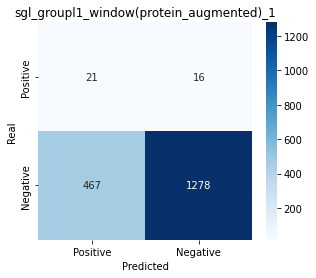

accuracy  : 72.89999999999999
precision : [98.76  4.3 ]
recall    : [73.24 56.76]
f1_score  : [84.11  8.  ]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0099778270509978
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_2of20.h5


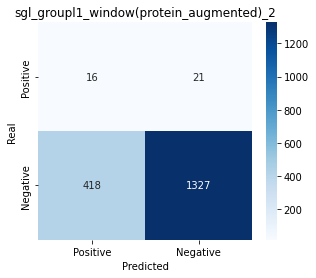

accuracy  : 75.36
precision : [98.44  3.69]
recall    : [76.05 43.24]
f1_score  : [85.81  6.79]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_3of20.h5


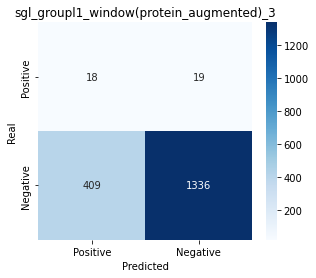

accuracy  : 75.98
precision : [98.6   4.22]
recall    : [76.56 48.65]
f1_score  : [86.19  7.76]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.032036613272311214 1.0102974828375288
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_4of20.h5


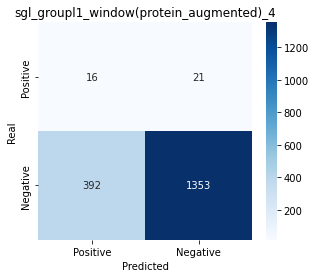

accuracy  : 76.82
precision : [98.47  3.92]
recall    : [77.54 43.24]
f1_score  : [86.76  7.19]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.037974683544303806 1.0103567318757194
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_5of20.h5


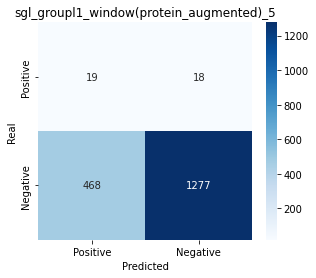

accuracy  : 72.72999999999999
precision : [98.61  3.9 ]
recall    : [73.18 51.35]
f1_score  : [84.01  7.25]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_6of20.h5


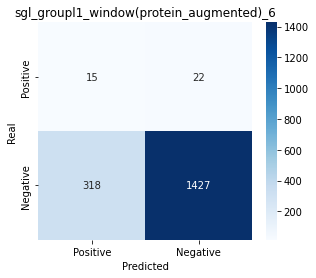

accuracy  : 80.92
precision : [98.48  4.5 ]
recall    : [81.78 40.54]
f1_score  : [89.36  8.11]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_7of20.h5


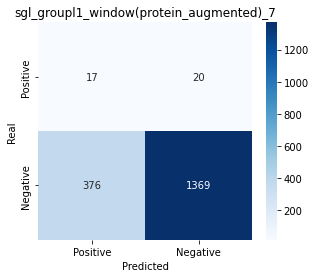

accuracy  : 77.78
precision : [98.56  4.33]
recall    : [78.45 45.95]
f1_score  : [87.36  7.91]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_8of20.h5


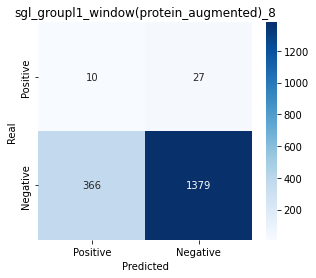

accuracy  : 77.95
precision : [98.08  2.66]
recall    : [79.03 27.03]
f1_score  : [87.53  4.84]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_9of20.h5


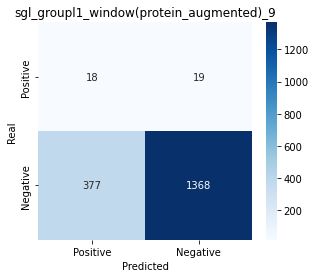

accuracy  : 77.78
precision : [98.63  4.56]
recall    : [78.4  48.65]
f1_score  : [87.36  8.33]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_10of20.h5


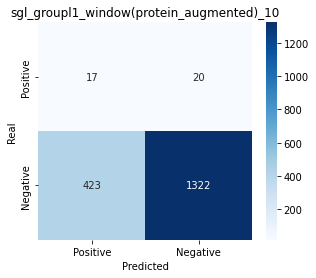

accuracy  : 75.14
precision : [98.51  3.86]
recall    : [75.76 45.95]
f1_score  : [85.65  7.13]

11th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_11of20.h5


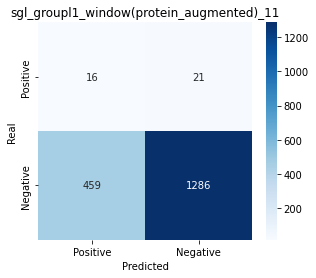

accuracy  : 73.06
precision : [98.39  3.37]
recall    : [73.7  43.24]
f1_score  : [84.27  6.25]

12th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_12of20.h5


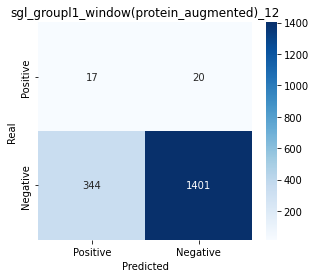

accuracy  : 79.57
precision : [98.59  4.71]
recall    : [80.29 45.95]
f1_score  : [88.5   8.54]

13th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0167410714285714
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_13of20.h5


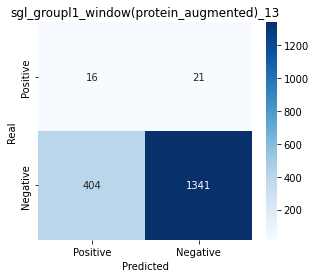

accuracy  : 76.14999999999999
precision : [98.46  3.81]
recall    : [76.85 43.24]
f1_score  : [86.32  7.  ]

14th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_14of20.h5


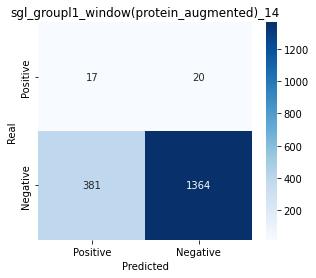

accuracy  : 77.5
precision : [98.55  4.27]
recall    : [78.17 45.95]
f1_score  : [87.18  7.82]

15th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_15of20.h5


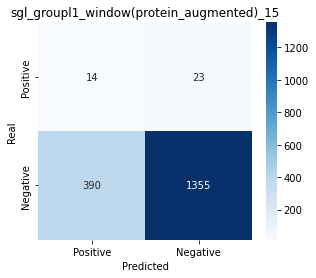

accuracy  : 76.82
precision : [98.33  3.47]
recall    : [77.65 37.84]
f1_score  : [86.78  6.35]

16th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_16of20.h5


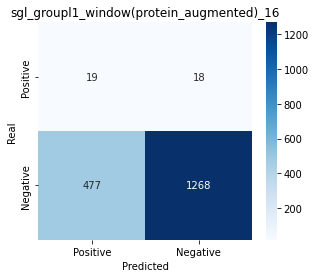

accuracy  : 72.22
precision : [98.6   3.83]
recall    : [72.66 51.35]
f1_score  : [83.67  7.13]

17th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_17of20.h5


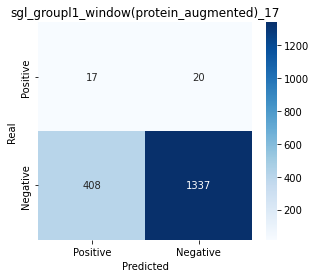

accuracy  : 75.98
precision : [98.53  4.  ]
recall    : [76.62 45.95]
f1_score  : [86.2   7.36]

18th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.032036613272311214 1.0102974828375288
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_18of20.h5


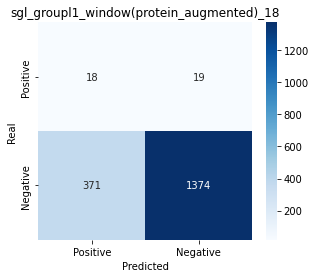

accuracy  : 78.11
precision : [98.64  4.63]
recall    : [78.74 48.65]
f1_score  : [87.57  8.45]

19th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_19of20.h5


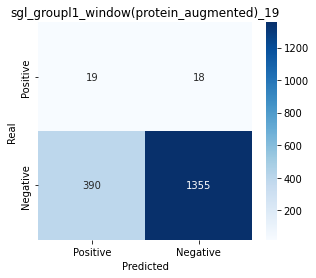

accuracy  : 77.10000000000001
precision : [98.69  4.65]
recall    : [77.65 51.35]
f1_score  : [86.91  8.52]

20th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 80) (7128, 1)
check scale: 0.0 1.0

test: (1782, 80) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 80) (13960, 1)
model has been restored from ./h5/sgl_groupl1_window(protein_augmented)_5_100_cv_20of20.h5


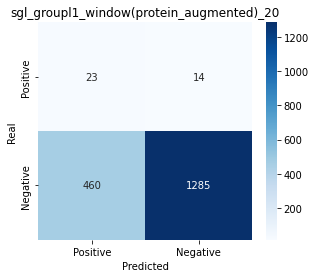

accuracy  : 73.4
precision : [98.92  4.76]
recall    : [73.64 62.16]
f1_score  : [84.43  8.85]


In [16]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    x_dim = train_x.shape[1]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

    model = SGL(x_dim, y_dim)
    model.build(n_layers, n_neurons, regularizer=L21())
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])